# Raport

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

In [4]:
data=pd.read_csv("train_egg_sales.csv",delimiter=';')

In [5]:
data.head()

,Date,Egg Sales
0,1993-01-01,91
1,1993-01-02,124
2,1993-01-03,112
3,1993-01-04,115
4,1993-01-05,107


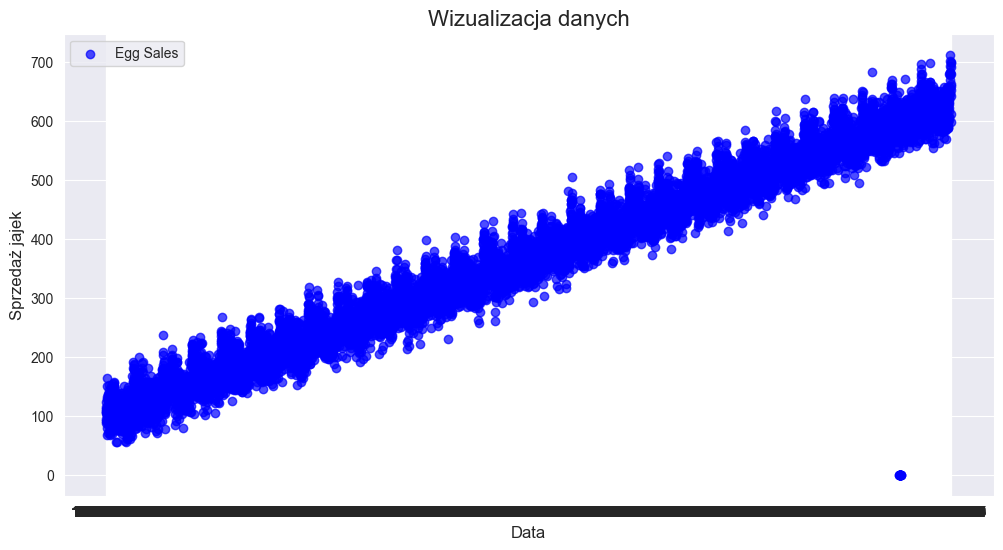

In [6]:
# Konwersja kolumny 'Date' na typ datetime, jeśli jeszcze tego nie zrobiono
#data['Date'] = pd.to_datetime(data['Date'])

# Wykres scatter
plt.figure(figsize=(12, 6))
plt.scatter(data['Date'], data['Egg Sales'], color='blue', alpha=0.7, label='Egg Sales')
plt.title('Wizualizacja danych', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Sprzedaż jajek', fontsize=12)
#plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


## 2.1

## N/A

In [7]:
print(data.isnull().sum()) #N/A
# Liczba brakujących danych w kolumnach
missing_data = data.isnull().sum()
print(f'Brakujące dane:\n{missing_data}')

# Możemy także sprawdzić brakujące dane w kontekście wartości sprzedaży jajek
missing_sales = data[data['Egg Sales'].isnull()]
print(f'Brakujące dane w sprzedaży jajek:\n{missing_sales}')


Date         0
Egg Sales    0
dtype: int64
Brakujące dane:
Date         0
Egg Sales    0
dtype: int64
Brakujące dane w sprzedaży jajek:
Empty DataFrame
Columns: [Date, Egg Sales]
Index: []


## detekcja wartości spoza zakładanego przedziału

In [8]:
min(data['Egg Sales'])

0

In [9]:
data.nsmallest(400, 'Egg Sales')

,Date,Egg Sales
9941,2020-03-21,0
9942,2020-03-22,0
9943,2020-03-23,0
9944,2020-03-24,0
9945,2020-03-25,0
...,...,...
189,1993-07-09,118
328,1993-11-25,118
446,1994-03-23,118
496,1994-05-12,118


In [10]:
max(data['Egg Sales'])

713

In [11]:
min_value=55
max_value=713
out_of_range_data = data[(data['Egg Sales'] < min_value) | (data['Egg Sales'] > max_value)]
print(f'Liczba próbek spoza zakładanego przedziału: {len(out_of_range_data)}')

Liczba próbek spoza zakładanego przedziału: 18


## Błedy w próbkowaniu

In [12]:
# Konwersja kolumny 'Date' na typ datetime, jeśli jeszcze tego nie zrobiono
data['Date'] = pd.to_datetime(data['Date'])

# Sprawdzenie różnic między kolejnymi datami
data['Time Diff'] = data['Date'].diff()

# Jeśli różnice czasowe są zbyt duże (np. > 1 dzień), może to wskazywać na brakujące próbki
irregular_dates = data[data['Time Diff'] > pd.Timedelta(days=1)]
print(f'Nieregularne daty (z dużą różnicą czasową):\n{irregular_dates}')


Nieregularne daty (z dużą różnicą czasową):
Empty DataFrame
Columns: [Date, Egg Sales, Time Diff]
Index: []


In [13]:
# Analiza wartości odstających (outliers) za pomocą IQR (Interquartile Range)
Q1 = data['Egg Sales'].quantile(0.25)
Q3 = data['Egg Sales'].quantile(0.75)
IQR = Q3 - Q1

# Zdefiniowanie przedziału wartości normalnych
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identyfikacja wartości odstających
outliers = data[(data['Egg Sales'] < lower_bound) | (data['Egg Sales'] > upper_bound)]
print(f'Wartości odstające (outliers):\n{outliers}')


Wartości odstające (outliers):
Empty DataFrame
Columns: [Date, Egg Sales, Time Diff]
Index: []


## 2.2

In [14]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data

,Date,Egg Sales,Time Diff
323,1993-11-20,147,1 days
9980,2020-04-29,617,1 days
1097,1996-01-03,177,1 days
9353,2018-08-11,558,1 days
6188,2009-12-11,456,1 days
...,...,...,...
5734,2008-09-13,374,1 days
5191,2007-03-20,346,1 days
5390,2007-10-05,344,1 days
860,1995-05-11,155,1 days


## 2.3

### wykres ACF oraz PACF dla surowych danych

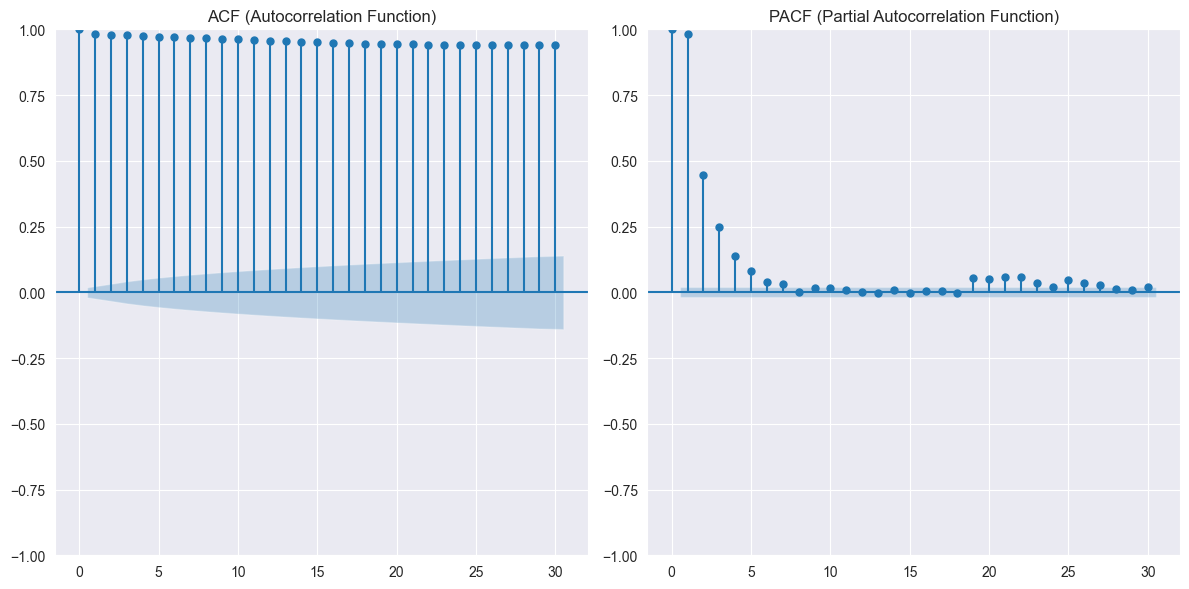

In [31]:
plt.figure(figsize=(12, 6))

# Wykres ACF (Autocorrelation Function)
plt.subplot(1, 2, 1)
plot_acf(data['Egg Sales'], lags=30, ax=plt.gca(), alpha=0.05) #wydaje mi sie ze powinnysmy uzywac data a nie train_data
plt.title("ACF (Autocorrelation Function)")

# Wykres PACF (Partial Autocorrelation Function)
plt.subplot(1, 2, 2)
plot_pacf(data['Egg Sales'], lags=30, ax=plt.gca(), alpha=0.05)
plt.title("PACF (Partial Autocorrelation Function)")

plt.tight_layout()
#(Boxa-Coxa),
plt.show()

### identyfikacja trendów deterministycznych: metody omawiane na wykładzie oraz na laboratorium -
(zadanie 4, lista 5) / różnicowanie / różnicowanie sezonowe / transformacje stabilizujące wariancję
(Boxa-Coxa),

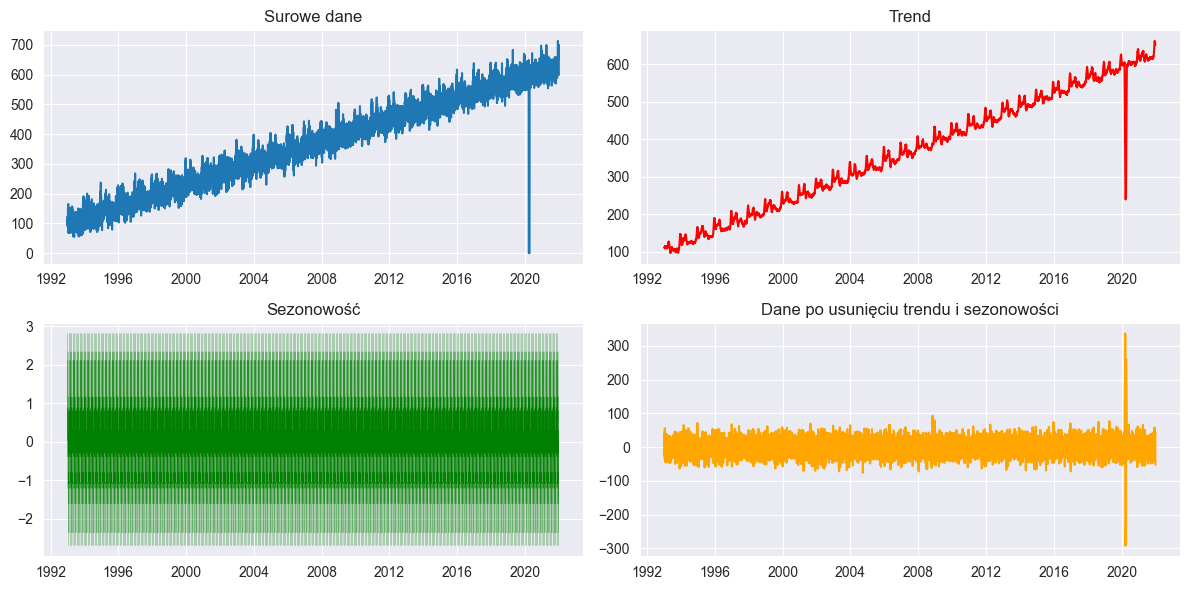

In [30]:
arma_trajectory_with_components = data['Egg Sales']
time = data['Date']
decomposition = seasonal_decompose(arma_trajectory_with_components, model='additive', period=30, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(time, arma_trajectory_with_components, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(time, trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(time, seasonal, label='Seasonal', color='green', lw=0.1)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(time, residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### ACF i PACF dla uzyskanego szeregu

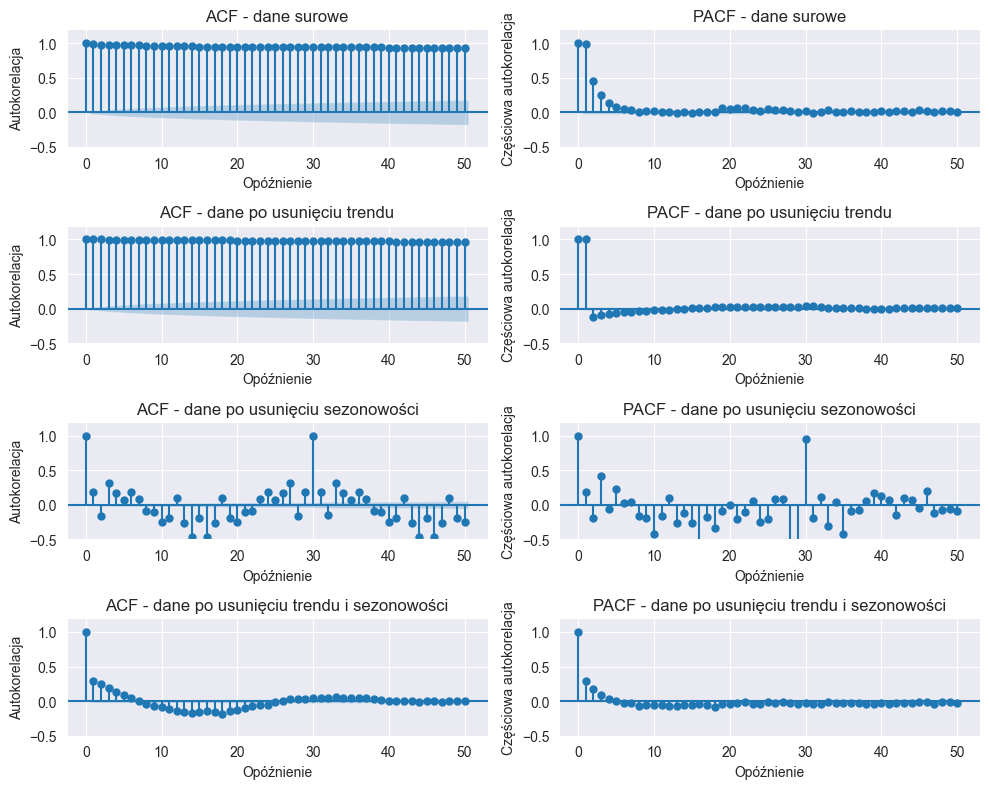

In [44]:
fig, axes = plt.subplots(4, 2, figsize=(10,8))

plot_acf(arma_trajectory_with_components, lags=50, ax=axes[0, 0])
axes[0, 0].set_xlabel('Opóźnienie')
axes[0, 0].set_ylabel('Autokorelacja')
axes[0, 0].set_title('ACF - dane surowe')
axes[0, 0].set_ylim(-0.5, 1.2)

plot_pacf(arma_trajectory_with_components, lags=50, ax=axes[0, 1])
axes[0, 1].set_xlabel('Opóźnienie')
axes[0, 1].set_ylabel('Częściowa autokorelacja')
axes[0, 1].set_title('PACF - dane surowe')
axes[0, 1].set_ylim(-0.5, 1.2)

plot_acf(trend, lags=50, ax=axes[1, 0])
axes[1, 0].set_xlabel('Opóźnienie')
axes[1, 0].set_ylabel('Autokorelacja')
axes[1, 0].set_title('ACF - dane po usunięciu trendu')
axes[1, 0].set_ylim(-0.5, 1.2)

plot_pacf(trend, lags=50, ax=axes[1, 1])
axes[1, 1].set_xlabel('Opóźnienie')
axes[1, 1].set_ylabel('Częściowa autokorelacja')
axes[1, 1].set_title('PACF - dane po usunięciu trendu')
axes[1, 1].set_ylim(-0.5, 1.2)

plot_acf(seasonal, lags=50, ax=axes[2, 0])
axes[2, 0].set_xlabel('Opóźnienie')
axes[2, 0].set_ylabel('Autokorelacja')
axes[2, 0].set_title('ACF - dane po usunięciu sezonowości')
axes[2, 0].set_ylim(-0.5, 1.2)

plot_pacf(seasonal, lags=50, ax=axes[2, 1])
axes[2, 1].set_xlabel('Opóźnienie')
axes[2, 1].set_ylabel('Częściowa autokorelacja')
axes[2, 1].set_title('PACF - dane po usunięciu sezonowości')
axes[2, 1].set_ylim(-0.5, 1.2)

plot_acf(residual, lags=50, ax=axes[3, 0])
#axes[2, 0].plot(acf_teor_, '-', label='Teoretyczna ACF')
axes[3, 0].set_xlabel('Opóźnienie')
axes[3, 0].set_ylabel('Autokorelacja')
axes[3, 0].set_title('ACF - dane po usunięciu trendu i sezonowości')
axes[3, 0].set_ylim(-0.5, 1.2)

plot_pacf(residual, lags=50, ax=axes[3, 1])
#axes[2, 1].plot(pacf_teor_, '-', label='Teoretyczna PACF')
axes[3, 1].set_xlabel('Opóźnienie')
axes[3, 1].set_ylabel('Częściowa autokorelacja')
axes[3, 1].set_title('PACF - dane po usunięciu trendu i sezonowości')
axes[3, 1].set_ylim(-0.5, 1.2)

plt.tight_layout()
plt.show()

### Test ADF weryfikujący hipotezę o niestacjonarności (Augmented Dickey-Fuller Test),

In [ ]:
def adfuller_test(series, sig=0.05):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1], 3)
    stats = round(res[0], 3)

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stacjonarny. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Niestacjonarny.")

In [39]:
print("Dla początkowego szeregu:")
adfuller_test(data['Egg Sales'])
print("\nDla oczyszczonego szeregu:")
adfuller_test(residual)

Dla początkowego szeregu:
Statystyka testowa = -1.609, p-value = 0.479 => Niestacjonarny.

Dla oczyszczonego szeregu:
Statystyka testowa = -27.99, p-Value = 0.0 => Stacjonarny. 


# 3.0 Modelowanie danych przy pomocy ARMA
### 3.1 dobranie rzędu modelu (kryteria informacyjne)

In [46]:
'''# Za pomocą kryteriow informacyjnych szukamy rzędu modelu, rozważamy ARMA(p,q), gdzie p, q = {0, 1, 2, 3}
# Współczynniki wielomianu AR i MA

p1 = 0.4
p2 = -0.5
q1 = 0.6
q2 = 0.3

ar_coef = np.array([1, -p1, -p2])
ma_coef = np.array([1, q1, q2])
# Tworzymy obiekt arma process

arma_process = ArmaProcess(ar_coef, ma_coef)
arma_process_trajectory = arma_process.generate_sample(nsample=traj_size, scale=sigma)'''


df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 4
max_q = 4

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(arma_trajectory_with_components, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC


In [48]:
df.sort_values(by='AIC').head()

,p,q,AIC,BIC,HQIC
5,1,1,98534.394489,98563.465906,98544.206904
6,1,2,98534.968911,98571.308183,98547.234430
9,2,1,98534.980570,98571.319841,98547.246089
13,3,1,98536.897616,98580.504742,98551.616239
7,1,3,98536.998279,98580.605404,98551.716901


Dla AIC najmniejsza wartość to 98534.394489, która odpowiada modelowi p = 1, q = 1.
Zatem na podstawie AIC najlepszy rząd modelu to p = 1, q = 1.

In [49]:
df.sort_values(by='BIC').head(1)

,p,q,AIC,BIC,HQIC
5,1,1,98534.394489,98563.465906,98544.206904


Na podstawie BIC najlepszy rząd modelu to p=1, q=1.

In [50]:
df.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
5,1,1,98534.394489,98563.465906,98544.206904


Na podstawie HQIC najlepszy rząd modelu to p=1, q=1.
Można też użyć do estymacji pakietu pmdarima

### 3.2 Estymacja parametrów modelu wybraną metodą
Yule Walker?